[ref](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
ngpu=0

In [5]:
n_samples = 10**5
n_feats = 10

In [6]:
x = np.random.randn(n_samples, n_feats)
w = np.random.randn(n_feats)
y = x.dot(w) + 2*np.random.randn(n_samples)

In [7]:
y.min(), y.max()

(-17.461931459782562, 18.27506294850586)

### Simple Linear Regression check

In [8]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)
reg.coef_

array([ 0.1605339 , -1.53735714,  1.34678078, -1.3396118 , -0.72620197,
        0.44939573,  1.19586859, -0.66062793, -1.04260257, -1.2790643 ])

In [9]:
w

array([ 0.15985127, -1.54090833,  1.34989083, -1.34604566, -0.73286599,
        0.45203237,  1.19547182, -0.66028083, -1.04284652, -1.27561863])

In [10]:
reg.score(x, y), (1-reg.score(x, y))*y.var()

(0.7356422937071577, 4.024607888156482)

### Define ANN Architecture

In [11]:
# Batch size during training
batch_size = 128

# Size of z latent vector (i.e. size of generator input)
nz = 5

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [12]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [13]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [14]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats+nz, 32, bias=True),
            nn.ReLU(True),

            nn.Linear( 32, 32, bias=True),
            nn.ReLU(True),

            nn.Linear( 32, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [16]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(n_feats+1, 32, bias=True), # i/p is covariates and o/p
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( 32, 32, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( 32, 1, bias=True),
            nn.Sigmoid(),

        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [18]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake_cpu = torch.hstack((data[0],fake.detach())).to(device)
        output = netD(fake_cpu.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_cpu = torch.hstack((data[0],fake)).to(device)
        output = netD(fake_cpu).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
        # Output validation stats
        if i % 10 == 0:
            with torch.no_grad():
                errG_vals = []
                errD_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    noise = torch.randn(b_size, nz, device=device)
                    # Generate fake image batch with G
                    gen_ip = torch.hstack((data[0],noise)).to(device)
                    gen_op = netG(gen_ip)
                    
                    fake_cpu = torch.hstack((data[0],gen_op)).to(device)
                    fake_output = netD(fake_cpu).view(-1)

                    label.fill_(real_label) # fake labels are real for generator cost
                    errG_val = criterion(output, label)  
                    
                    label.fill_(fake_label)
                    errD_fake_val = criterion(output, label)
                    
                    real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
                    real_output = netD(real_cpu).view(-1)
                    
                    label.fill_(real_label)
                    errD_real_val = criterion(output, label)
                    
                    errG_vals.append(errG_val.item())
                    errD_vals.append((errD_fake_val+errD_real_val).item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
            D_losses_val.append(sum(errD_vals)/len(errD_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_set)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.4151	Loss_G: 0.6403	D(x): 0.5148	D(G(z)): 0.5271 / 0.5274
[0/5][50/469]	Loss_D: 1.3847	Loss_G: 0.8354	D(x): 0.4907	D(G(z)): 0.4562 / 0.4442
[0/5][100/469]	Loss_D: 1.3877	Loss_G: 0.6793	D(x): 0.5178	D(G(z)): 0.5135 / 0.5091
[0/5][150/469]	Loss_D: 1.3838	Loss_G: 0.7284	D(x): 0.4942	D(G(z)): 0.4915 / 0.4840
[0/5][200/469]	Loss_D: 1.3831	Loss_G: 0.6969	D(x): 0.4997	D(G(z)): 0.4968 / 0.4988
[0/5][250/469]	Loss_D: 1.3818	Loss_G: 0.6799	D(x): 0.5122	D(G(z)): 0.5089 / 0.5075
[0/5][300/469]	Loss_D: 1.3806	Loss_G: 0.6835	D(x): 0.5098	D(G(z)): 0.5055 / 0.5055
[0/5][350/469]	Loss_D: 1.3908	Loss_G: 0.6911	D(x): 0.4975	D(G(z)): 0.4986 / 0.5012
[0/5][400/469]	Loss_D: 1.3873	Loss_G: 0.7249	D(x): 0.4886	D(G(z)): 0.4881 / 0.4855
[0/5][450/469]	Loss_D: 1.3864	Loss_G: 0.6832	D(x): 0.5052	D(G(z)): 0.5049 / 0.5051
[1/5][0/469]	Loss_D: 1.3866	Loss_G: 0.7103	D(x): 0.4925	D(G(z)): 0.4924 / 0.4916
[1/5][50/469]	Loss_D: 1.3916	Loss_G: 0.7122	D(x): 0.4940	D(G(z)): 

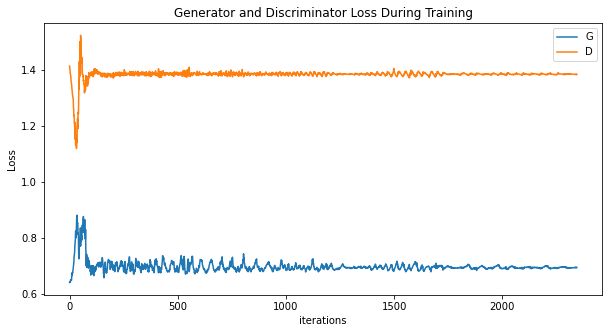

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

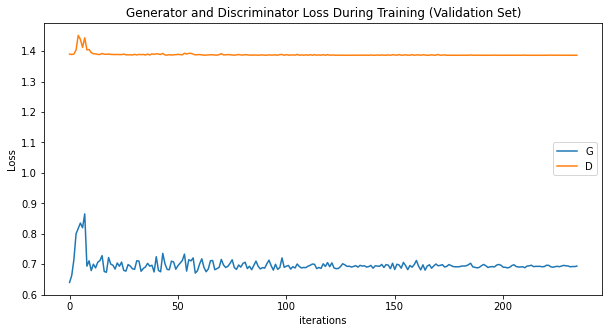

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (Validation Set)")
plt.plot(G_losses_val,label="G")
plt.plot(D_losses_val,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [22]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [23]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [24]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,60000.000000,60000.000000
mean,0.010225,-0.265290
std,3.904441,3.743593
min,-17.278040,-15.767388
25%,-2.625787,-2.911639
50%,0.012197,-0.270431
75%,2.646421,2.369000
max,18.275063,15.332878


In [25]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-15.767999999999999, -5.087]",-4.952946,-6.725975
"(-5.087, -3.521]",-3.046519,-4.244837
"(-3.521, -2.359]",-1.974679,-2.921216
"(-2.359, -1.29]",-1.166662,-1.818140
"(-1.29, -0.27]",-0.367435,-0.780017
"(-0.27, 0.723]",0.374292,0.228241
"(0.723, 1.784]",1.172230,1.249002
"(1.784, 3.014]",2.091215,2.378886
"(3.014, 4.596]",3.022470,3.752503


In [26]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(7.9151497, 15.244657)

## Test Predictions

In [27]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [28]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [29]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,0.006454,-0.265945
std,3.890019,3.702449
min,-15.845773,-14.583967
25%,-2.604486,-2.876529
50%,0.004577,-0.260689
75%,2.619241,2.313896
max,15.502691,12.841071


In [30]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-14.584999999999999, -5.026]",-4.997673,-6.653663
"(-5.026, -3.483]",-2.983277,-4.179932
"(-3.483, -2.332]",-2.003040,-2.885709
"(-2.332, -1.261]",-1.200230,-1.810161
"(-1.261, -0.261]",-0.342872,-0.757957
"(-0.261, 0.686]",0.331427,0.207687
"(0.686, 1.733]",1.229089,1.210060
"(1.733, 2.92]",2.037019,2.323563
"(2.92, 4.522]",3.018151,3.687000


In [31]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(7.7404447, 15.132245)

## Test Predictions (averaged)

In [32]:
N_SAMPLES = 100
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        fakes = []
        for _ in range(N_SAMPLES):
            noise = torch.randn(b_size, nz, device=device)
            # Generate fake image batch with G
            gen_ip = torch.hstack((data[0],noise)).to(device)
            fake = netG(gen_ip).detach().cpu().numpy()
            fakes.append(fake)

        test_ops.append(
            (data[1].detach().cpu().numpy(), sum(fakes)/len(fakes))
        )
# print(test_reals.shape,np.concatenate(list(x[0] for x in test_ops)).shape)
# print(test_preds.shape,np.concatenate(list(x[1] for x in test_ops)).shape)
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))


In [33]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,0.006454,-0.252292
std,3.890019,3.221404
min,-15.845773,-11.830221
25%,-2.604486,-2.547036
50%,0.004577,-0.283550
75%,2.619241,2.052713
max,15.502691,11.957608


In [34]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-11.831, -4.405]",-5.762515,-5.813342
"(-4.405, -3.095]",-3.499929,-3.707593
"(-3.095, -2.059]",-2.239505,-2.561866
"(-2.059, -1.143]",-1.344558,-1.588658
"(-1.143, -0.284]",-0.362307,-0.702079
"(-0.284, 0.635]",0.440095,0.177845
"(0.635, 1.581]",1.271477,1.096797
"(1.581, 2.62]",2.250642,2.072290
"(2.62, 3.943]",3.434564,3.246716


In [35]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(4.208647, 15.132245)